In [1]:
#pip install statsmodels

In [2]:
#pip install yfinance

In [3]:
#pip install pandas_datareader

In [4]:
import pandas as pd 
import pandas_datareader as pdr 
import datetime
import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

#relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')


In [5]:
btc = yfin.download(['BTC-USD'], start="2018-01-01",end="2020-12-2")

btc.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [6]:
btc = btc['Close']
btc.to_csv("btc.csv")
btc = pd.read_csv("btc.csv")
btc.head(5)

,Date,Close
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000


In [7]:
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
del btc['Date']

btc.head(5)

,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


In [21]:
# To get the number of rows in the DataFrame
num_rows = len(btc)

# Alternatively, you can use the shape attribute to get both rows and columns count
rows, columns = btc.shape

# Printing number of rows
print("Number of rows:", num_rows)
# Printing rows and columns
print("DataFrame shape: (rows, columns) =", btc.shape)


Number of rows: 1066
DataFrame shape: (rows, columns) = (1066, 1)


In [24]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1066 entries, 2018-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1066 non-null   float64
dtypes: float64(1)
memory usage: 16.7 KB


In [22]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())  # Handling any NaN values by dropping them
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]
    print(f'ADF Statistic: {adf_stat}')
    print(f'p-value: {p_value}')
    for key, value in critical_values.items():
        print(f'Critical Value ({key}): {value}')

# Assuming 'hourly_sentiment_average' is your Series name
check_stationarity(btc)


ADF Statistic: -0.9022061957212526
p-value: 0.7872450175172638
Critical Value (1%): -3.436510851955201
Critical Value (5%): -2.864260220574562
Critical Value (10%): -2.5682183458999943


In [25]:
import numpy as np
from scipy.signal import welch

def spectral_entropy(series, sf=1.0, normalize=True):
    # Drop any NaN values from the series and use Welch's method to estimate power spectral density
    f, Pxx = welch(series.dropna(), sf)  
    # Normalize the power spectral densities so that they form a probability distribution
    psd_norm = Pxx / np.sum(Pxx)
    # Calculate the entropy of the distribution using the Shannon entropy formula
    entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))
    # Normalize the entropy to a scale of 0 to 1 by dividing by the log2 of the number of points if required
    if normalize:
        entropy /= np.log2(len(psd_norm))
    return entropy

# Assuming 'btc' is your DataFrame and 'Close' is the column you want to analyze
entropy = spectral_entropy(btc['Close'])
print(f'Spectral Entropy: {entropy}')


Spectral Entropy: 0.3720569868535276


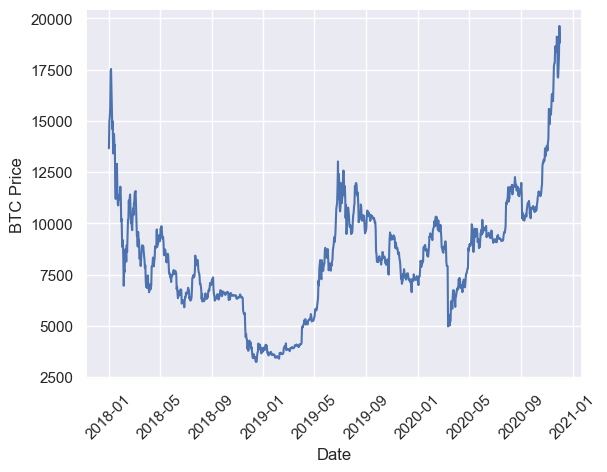

In [8]:
sns.set()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'], )
plt.show()

In [9]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = btc[btc.index >= pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test

,Close
Date,
2020-11-01,13737.109375
2020-11-02,13550.489258
2020-11-03,13950.300781
2020-11-04,14133.707031
2020-11-05,15579.848633
2020-11-06,15565.880859
2020-11-07,14833.753906
2020-11-08,15479.567383
2020-11-09,15332.315430


In [26]:
train

,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000
2018-01-06,17527.000000
2018-01-07,16477.599609
2018-01-08,15170.099609
2018-01-09,14595.400391


In [27]:
test

,Close
Date,
2020-11-01,13737.109375
2020-11-02,13550.489258
2020-11-03,13950.300781
2020-11-04,14133.707031
2020-11-05,15579.848633
2020-11-06,15565.880859
2020-11-07,14833.753906
2020-11-08,15479.567383
2020-11-09,15332.315430


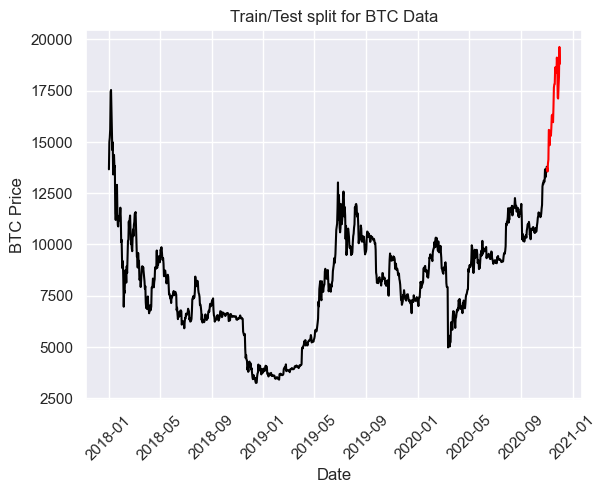

In [10]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

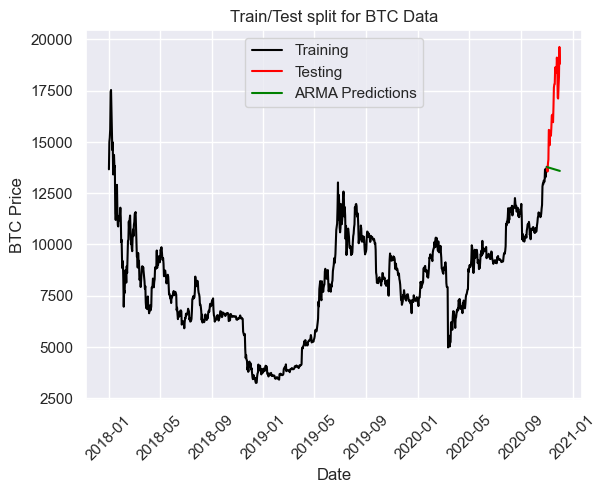

In [11]:
y = train['Close']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARMA = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("ARMA RMSE: ",arma_rmse)

ARMA RMSE:  3509.5596420896936


In [13]:
#ARIMAmodel = SARIMAX(y, order = (2, 2, 2))
#ARIMAmodel = SARIMAX(y, order = (2, 3, 2))
ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"]

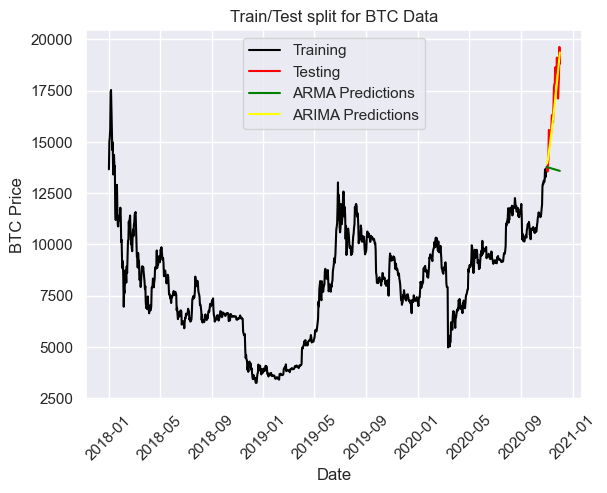

In [14]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

In [15]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("ARIMA RMSE: ",arma_rmse)

ARIMA RMSE:  811.3483846038431


In [16]:
SARIMAXmodel = SARIMAX(y, order = (2,2,2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0],
                                                end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outSARIMAX = y_pred_df["Predictions"] 

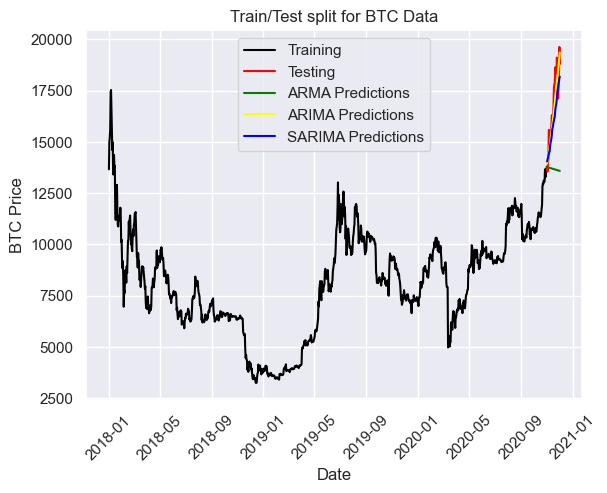

In [17]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_outSARIMAX, color='Blue', label = 'SARIMA Predictions')
plt.legend()
plt.show()

In [18]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("SARIMA RMSE: ",arma_rmse)

SARIMA RMSE:  1085.5271766815033
